# HABSlib 102

In this first notebook, we will move our first steps into the HABSlib client library for the HABS BrainOS API.    
This library allows you to record, store safely, and analyze EEG data, using the HABS BrainOS platform.

In this first crash course, we will look at installation, handshake, using the HABS generator of dummy EEG signals, and perform several analyses on them.

## Installation
First, we install the necessary libraries.    
- HABSlib
- nest_asyncio (to allow HABSlib to run in a Jupyter notebook, which has already a async loop in each cell)

In [2]:
pip install HABSlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [3]:
hb.handshake(base_url="http://74.249.61.11", user_id='666c0158fcbfd9a830399121')


     ---------------------------------------------------------------------------------- 
     HHHHHH       HHHHHH        AAAAAAAAA        BBBBBBBBBBBBBB          SSSSSSSSSSS    
     HHHHHH       HHHHHH       AAAAAAAAAA        BBBBBBBBBBBBBBBBB    SSSSSSSSSSSSSSSS  
     HHHHHH       HHHHHH       AAAAAAAAAAA       BBBBBBBBBBBBBBBBBB   SSSSSS    SSSSSSS 
     HHHHHH       HHHHHH      AAAAAA AAAAAA                  BBBBBB   SSSSS             
     HHHHHHHHHHHHHHHHHHH     AAAAAA  AAAAAAA     BBBBBBBBBBBBBBBB     SSSSSSSSSSSSSS    
     HHHHHHHHHHHHHHHHHHH     AAAAAA   AAAAAA     BBBBBBBBBBBBBBBBB       SSSSSSSSSSSSSS 
     HHHHHH       HHHHHH    AAAAAA     AAAAAA    BBBBB       BBBBBB              SSSSSS 
     HHHHHH       HHHHHH   AAAAAA       AAAAAA   BBBBBBBBBBBBBBBBBB  SSSSSSS    SSSSSSS 
     HHHHHH       HHHHHH  AAAAAAA       AAAAAA   BBBBBBBBBBBBBBBBBB   SSSSSSSSSSSSSSSS  
     HHHHHH       HHHHHH  AAAAAA         AAAAAA  BBBBBBBBBBBBBB         SSSSSSSSSSSS    
     ---------------

True

## Get user data
You can query the user data stored on the server

In [4]:
user_data = hb.get_user_by_id(user_id='666c0158fcbfd9a830399121')
print(user_data)

User found.
{'_id': {'$oid': '666c0158fcbfd9a830399121'}, 'user_data': {'first_name': 'Domenico', 'last_name': 'Guarino', 'role': 'Admin', 'group': 'HABS', 'email': 'domenico@habs.ai', 'age': 50.0, 'weight': 89.0, 'gender': 'M'}}


In [5]:
import numpy as np

results = hb.get_data_by_session(user_id='666c0158fcbfd9a830399121', session_id='667e657c0170ea4156d56061')
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(4, 46080)
[[ -7.32421875 -23.4375     -22.4609375  ...  55.17578125  45.8984375
   51.26953125]
 [ -5.37109375  -7.8125     -11.71875    ... -15.625      -20.99609375
  -17.08984375]
 [-20.01953125 -24.90234375 -27.83203125 ... -38.0859375  -45.8984375
  -36.1328125 ]
 [-16.11328125 -13.671875    -5.859375   ...  66.40625     63.4765625
   64.453125  ]]


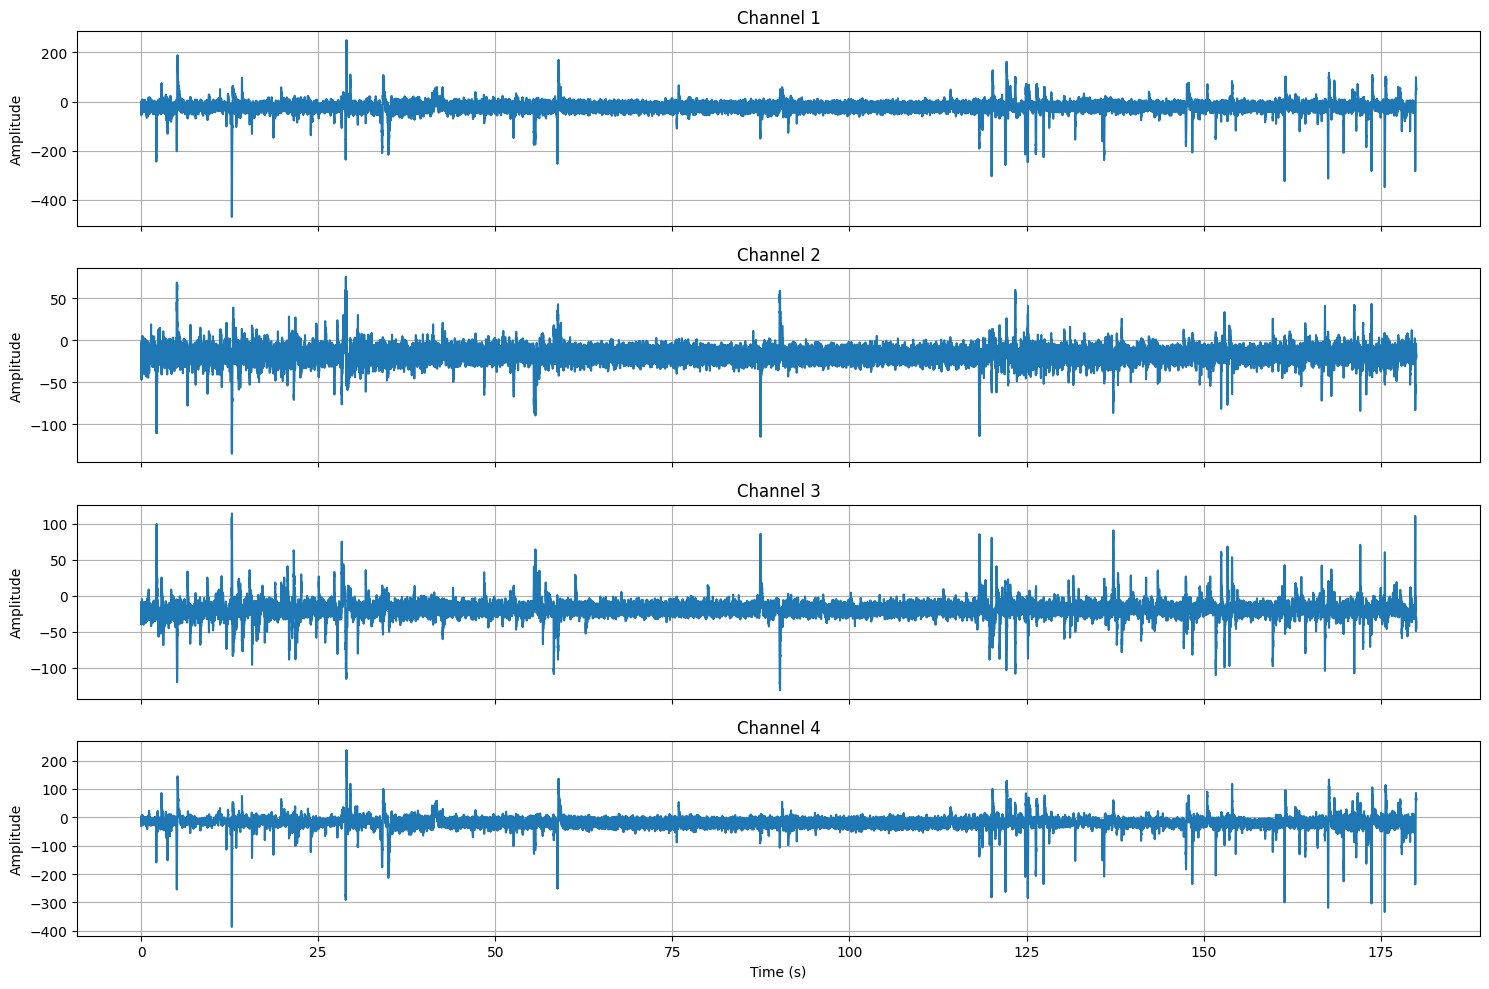

In [6]:
import matplotlib.pyplot as plt

samples_per_second = 256
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

Let's look at the frequency content

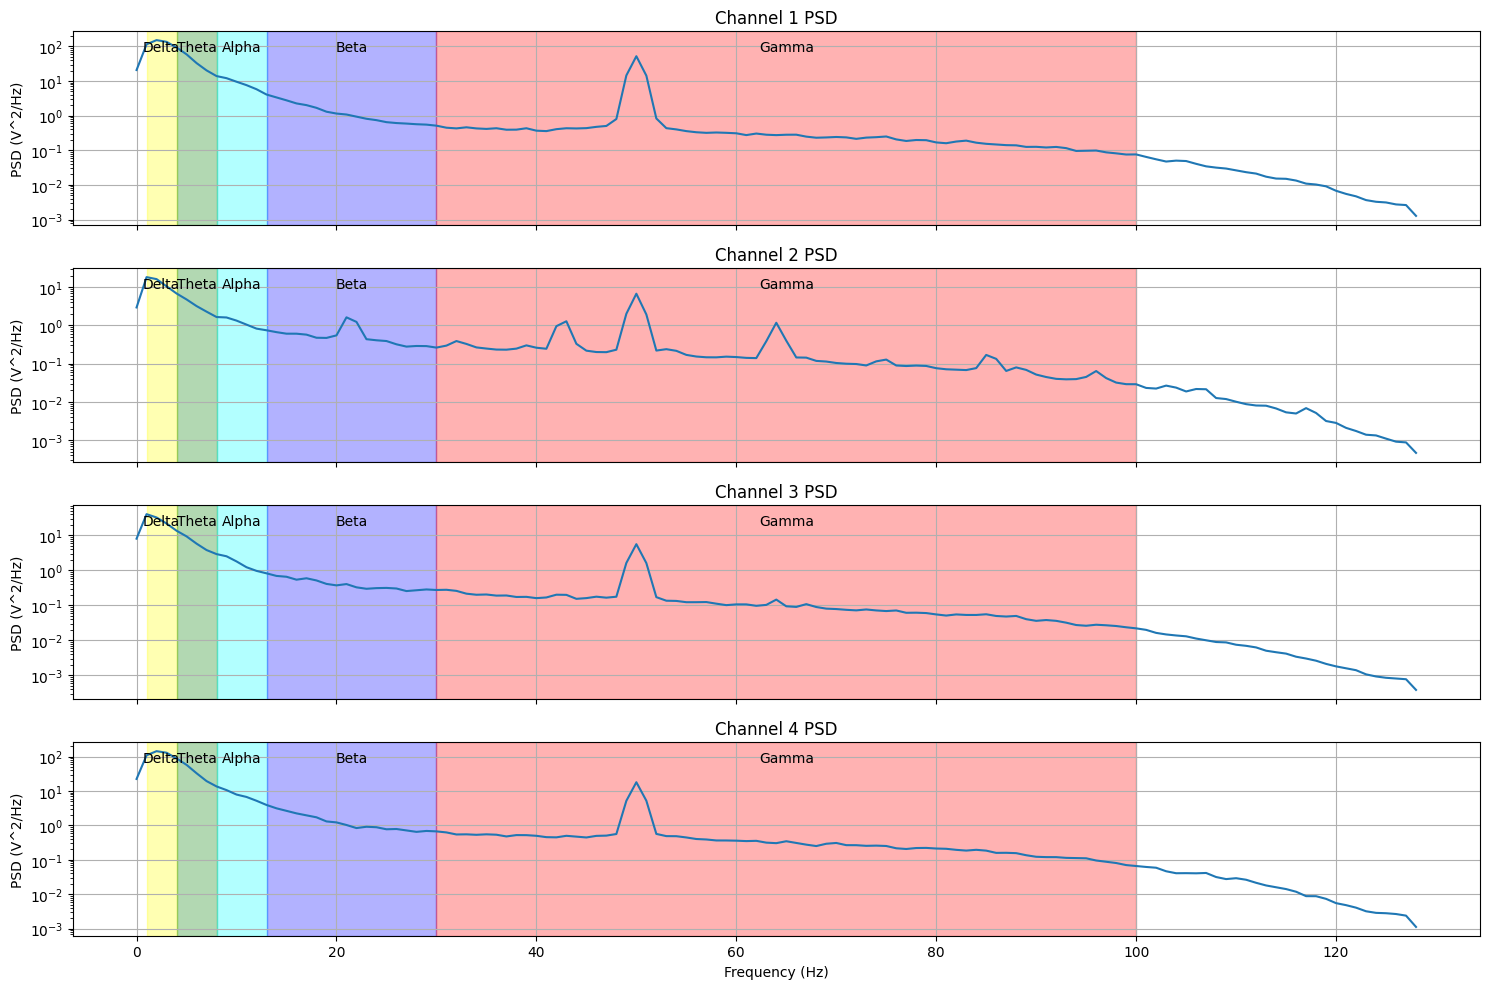

In [7]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### Feature extraction
We compute kurtosis over 5sec intervals of the signal. No overlap between windows for now.    
For simplicity, we label values as significant if they are more than two standard deviations above the mean kurtosis.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis

In [19]:
def calculate_kurtosis(eegdata, window_size):
    kurtosis_data = [[] for i in range(len(eegdata))]
    for ch,channel in enumerate(eegdata):
        for i in range(0, len(channel) - window_size, window_size):
            kurtosis_data[ch].append( kurtosis(channel[i:i+window_size]) )
    # print(kurtosis_data)
    return kurtosis_data

window_size = 5 * 256
kurtosis_values = calculate_kurtosis(data, window_size)

# Generate synthetic labels (Replace with actual labels)
# labels = np.random.choice([0, 1], size=len(kurtosis_values))

# Labels
# Mean and std of kurtosis values
data_mean_kurtosis = np.mean(kurtosis_values, axis=1, keepdims=True)
data_std_kurtosis = np.std(kurtosis_values, axis=1, keepdims=True)
# print(data_mean_kurtosis)
# print(data_std_kurtosis)
labels = [[] for i in range(len(kurtosis_values))]
for ch,channel in enumerate(kurtosis_values):
    for i,kur in enumerate(channel):
        labels[ch].append(0)
        if kur > (data_mean_kurtosis[ch]+data_std_kurtosis[ch]): # one std above mean
            labels[ch][i] = 1
# print(labels)
for ch,channel in enumerate(labels):
    print(ch, np.any(channel))
# print(labels[3])

0 True
1 True
2 True
3 True


### 2. Feature extraction and data splitting

In [24]:
# In this case, the feature is already extracted as 'kurtosis'
features = np.array(kurtosis_values)
target = np.array(labels)
# print(features)
# print(target)

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(features, target.flatten(), test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features.flatten(), target.flatten(), test_size=0.2, random_state=42)
print(X_train)
print(y_train)

[-0.62584017  3.17838717  7.06493085  6.54549723 21.44846837  3.73857477
 -0.166412    4.23066827  5.83470666 17.7162587   4.23261898 15.2235274
  0.04220684  1.75512867  4.82602739  5.24057489 11.88998956 -0.27133943
 10.28695377  1.76280592  3.23113695  2.91260806  0.22007509  2.7431579
  1.23444589  9.90355558  4.19153621  3.8175448  -0.07075273  6.25829426
  0.66491067  4.46092001  0.65760385 16.96351455  1.1560021   8.212335
  3.67579686  5.33530418  4.35639708  9.4456128  13.96078543 13.86058225
  1.8521401   0.19884717 -0.05091256 13.28734176 16.56897237  8.72672966
  5.71943208  1.52926872 14.52075853 -0.07831457 -0.40577096  4.06404399
  0.92885802 -0.57048504  3.14204117  6.47991034 10.9044028   0.55052002
  8.78241046  0.50310529  6.16275814 10.78160258 -0.33484755  6.27970461
 -0.11229812 -0.11830836  3.24274447  4.91631983  7.96695981  1.35358963
 21.01028528  4.76589513  3.89892315 -0.04385467  1.15623971 19.28068489
  0.5252668  -0.20971583 22.39675102  3.39283037  0.076

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train SVM for classification
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(X_train, y_train.reshape(-1, 1))

# Predict and evaluate
y_pred = svm_classifier.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


ValueError: Expected 2D array, got 1D array instead:
array=[-0.62584017  3.17838717  7.06493085  6.54549723 21.44846837  3.73857477
 -0.166412    4.23066827  5.83470666 17.7162587   4.23261898 15.2235274
  0.04220684  1.75512867  4.82602739  5.24057489 11.88998956 -0.27133943
 10.28695377  1.76280592  3.23113695  2.91260806  0.22007509  2.7431579
  1.23444589  9.90355558  4.19153621  3.8175448  -0.07075273  6.25829426
  0.66491067  4.46092001  0.65760385 16.96351455  1.1560021   8.212335
  3.67579686  5.33530418  4.35639708  9.4456128  13.96078543 13.86058225
  1.8521401   0.19884717 -0.05091256 13.28734176 16.56897237  8.72672966
  5.71943208  1.52926872 14.52075853 -0.07831457 -0.40577096  4.06404399
  0.92885802 -0.57048504  3.14204117  6.47991034 10.9044028   0.55052002
  8.78241046  0.50310529  6.16275814 10.78160258 -0.33484755  6.27970461
 -0.11229812 -0.11830836  3.24274447  4.91631983  7.96695981  1.35358963
 21.01028528  4.76589513  3.89892315 -0.04385467  1.15623971 19.28068489
  0.5252668  -0.20971583 22.39675102  3.39283037  0.07691432  0.2338161
  4.37404616 25.84979999 13.66626014  4.57673331  1.55280018  3.61230201
 13.82673845  9.94448668 34.79362235 11.19986116 13.37276046 22.18616464
 -0.52711229 37.66591153 15.36922452  6.32495447  5.16024118 11.96829994
 21.25735062  3.95818147 -0.2782926  16.91355897 -0.47171187  8.73254395
 19.95950802 -0.49911044  0.77827983  5.01104079].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Training an SVR for regression

In [24]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Prepare data for regression (Using previous kurtosis values to predict the next one)
print(len(kurtosis_values))

# X_reg = np.array([kurtosis_values[i:i+3] for i in range(len(kurtosis_values) - 3)])
kurtosis_Xreg = [[] for i in range(len(kurtosis_values))]
for ch,channel in enumerate(kurtosis_values):
    # print(ch,channel)
    for i in range(len(channel) - 3):
        kurtosis_Xreg[ch].append( channel[i:i+3] )
X_reg = np.array(kurtosis_Xreg[0])
    
# y_reg = np.array([kurtosis_values[i+3] for i in range(len(kurtosis_values) - 3)])
kurtosis_yreg = [[] for i in range(len(kurtosis_values))]
for ch,channel in enumerate(kurtosis_values):
    for i in range(len(channel) - 3):
        kurtosis_yreg[ch].append( channel[i+3] )
y_reg = np.array(kurtosis_yreg[0])

# print(X_reg, y_reg)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
print("training", X_train_reg)
print("testing", y_train_reg)

# Train SVR for regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_reg, y_train_reg)

# Predict and evaluate
y_pred_reg = svr_model.predict(X_test_reg)
print("Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg))


16
training [[ 4.75922439e+00 -2.62535914e-02  9.44527704e+00]
 [ 1.56183828e-01  1.56518039e+01  1.88952679e+01]
 [ 5.04444096e+00  1.57060857e+01  3.02365615e+01]
 [ 4.96959096e+00  6.30502919e+00  1.03995114e+01]
 [ 2.19741358e+00  2.03952579e+00  2.24528268e+01]
 [ 6.30502919e+00  1.03995114e+01  2.34535990e+01]
 [ 1.56518039e+01  1.88952679e+01  3.13482614e+00]
 [ 1.38752867e+01  1.56183828e-01  1.56518039e+01]
 [ 8.54568223e+00  8.35506126e+00  4.75922439e+00]
 [ 1.57060857e+01  3.02365615e+01  1.44779904e+01]
 [ 3.02365615e+01  1.44779904e+01  4.96959096e+00]
 [-2.62535914e-02  9.44527704e+00  2.43004883e-01]
 [ 1.44779904e+01  4.96959096e+00  6.30502919e+00]
 [ 1.73523487e-02  8.71516838e+00  8.54568223e+00]
 [ 9.44527704e+00  2.43004883e-01  3.62723262e+01]
 [ 8.71516838e+00  8.54568223e+00  8.35506126e+00]
 [ 2.24528268e+01  1.56162861e-01  5.87632416e+00]
 [ 1.50769104e-01  2.39981074e+01  1.64610580e+01]
 [ 5.87632416e+00  1.73523487e-02  8.71516838e+00]
 [ 2.34535990e+01  